# Bayesian Optimization with XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read Data
Use all data for a better score. However i've not been able to properly configure the K80 gpu available on kaggle to work with xgboost, so I've had to severly limit both the amount of data, and size of model.

The data appears to be randomized, so reading in the beginning rows is acceptable.

Using the entire dataset will use around 32gb of memory throughout this notebook, So primarily for this reason I achieved first place on the leaderboard as of July 31,2018 using an AWS EC2 p3.2xlarge instance.

In [40]:
df = pd.read_csv('train.csv', nrows = 2000000,
                usecols = [1,2,3,4,5,6,7])

In [41]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Slicing off unecessary components of the datetime and specifying the date format results in a MUCH more efficiecnt conversion to a datetime object.

In [42]:
df['pickup_datetime'] = df['pickup_datetime'].str.slice(0,16)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True,
                                      format = '%Y-%m-%d %H:%M')

# Clean

In [43]:
# Remove observations with missing values
# Since ther are only few of these, i'm not concerned wiht imputation
df.dropna(how='any', axis='rows', inplace=True)

# Removing observations with erroneous values
mask = df['pickup_longitude'].between(-75,-73)
mask &= df['dropoff_longitude'].between(-75, -73)
mask &= df['pickup_latitude'].between(40, 42)
mask &= df['dropoff_latitude'].between(40,42)
mask &= df['passenger_count'].between(0,8)
mask &= df['fare_amount'].between(0,250)
df = df[mask]

# Feature Engineering
Manhattan distance provides a better approximation of actual travelled distance than harvesine for mostr trips.

In [44]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    return distance 

See NYC Taxi Fare - Data Exploration for an excellent EDA on this dataset and the intuition for including ariports.

In [45]:
def transform(data):
    # Extract date attributions and then drop the pick up_datetime column
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day'] = data['pickup_datetime'].dt.day
    data['month'] = data['pickup_datetime'].dt.month
    data['year'] = data['pickup_datetime'].dt.year
    data = data.drop('pickup_datetime', axis = 1)
    
    # Distance to nearby airports, and city center
    # By reporting distnaces to these points, the model can somewhat triangulate other locations of interest
    
    nyc = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    data['distance_to_center'] = dist(nyc[1], nyc[0], data['pickup_latitude'],
                                     data['pickup_longitude'])
    data['pickup_distance_to_jfk'] = dist(jfk[1], jfk[0], data['pickup_latitude'],
                                                              data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = dist(jfk[1], jfk[0], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = dist(ewr[1], ewr[0], data['pickup_latitude'],
                                                              data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = dist(ewr[1], ewr[0], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = dist(lgr[1], lgr[0], data['pickup_latitude'],
                                                              data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = dist(lgr[1], lgr[0], data['dropoff_latitude'], data['dropoff_longitude'])
    data['long_dist'] = data['pickup_longitude'] - data['dropoff_longitude']
    data['lat_dist'] = data['pickup_latitude'] - data['dropoff_latitude']
    
    return data

df = transform(df)

# Train/Test split

In [46]:
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

Being careful about memeory management, which is critical when running the entire dataset.

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('fare_amount', axis=1), df['fare_amount'], test_size=0.25)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Training
Optimizing hyperparameters with bayesian optimization. I've tried to limit the scope of the search as much as possible since the search space grows exponentially when considering aditional hyperparameters.

GPU acceleration with a few pre tuned hyperparameters speeds up the search a lot.

In [48]:
def xgb_evaluate(max_depth, gamma, min_child_weight, max_delta_step,
                subsample, colsample_bytree):
    params = {'eval_metric' : 'rmse',
             'max_depth' : int(max_depth),
             'subsample' : subsample,
             'eta' : 0.1,
             'gamma': gamma,
             'colsample_bytree' : colsample_bytree,
             'min_child_weight' : min_child_weight,
             'max_delta_step' : max_delta_step}
    
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [49]:
%%time
xgb_bo = BayesianOptimization(xgb_evaluate, {
    'max_depth' : (2,12),
    'gamma' : (0.01, 10.0),
    'min_child_weight' : (0, 20),
    'max_delta_step' : (0, 10),
    'subsample' : (0.4, 1.0),
    'colsample_bytree' : (0.4, 1.0)
})
# Use the expected imporovement acquisition function to handle negative numbers
# Optimally need quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points = 10, n_iter = 20, acq = 'ei')

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -4.21     |  0.8817   |  8.637    |  4.797    |  8.064    |  13.3     |  0.7968   |
|  2        | -4.175    |  0.4784   |  5.264    |  9.427    |  4.209    |  2.278    |  0.4648   |
|  3        | -11.09    |  0.7223   |  5.545    |  0.5353   |  6.454    |  7.416    |  0.889    |
|  4        | -4.176    |  0.7945   |  7.237    |  5.207    |  7.322    |  2.53     |  0.411    |
|  5        | -5.955    |  0.8674   |  9.072    |  2.843    |  3.204    |  13.22    |  0.6125   |
|  6        | -3.726    |  0.956    |  6.07     |  9.05     |  11.24    |  15.19    |  0.8204   |
|  7        | -9.918    |  0.8479   |  8.35     |  0.8532   |  3.186    |  15.95    |  0.9941   |
|  8        | -4.048    |  0.8298   |  3.008    |  6.043    |  7.22     |  0.8191   |  0.5077   |
|  9        | -4.138

KeyboardInterrupt: 

In [50]:
#params = xgb_bo.max
params = {'max_depth': 12.0, 'gamma': 0.001, 
          'min_child_weight': 8.740952582296343, 
          'max_delta_step': 10.0, 'subsample': 0.4, 
          'colsample_bytree': 1.0}
params['max_depth'] = int(params['max_depth'])

In [51]:
params

{'colsample_bytree': 1.0,
 'gamma': 0.001,
 'max_delta_step': 10.0,
 'max_depth': 12,
 'min_child_weight': 8.740952582296343,
 'subsample': 0.4}

# Testing 

In [52]:
# Train a new model with the best parameters from search
model2 = xgb.train(params, dtrain, num_boost_round = 250)

# Predict on testing and training set
y_pred = model2.predict(dtest)
y_train_pred = model2.predict(dtrain)

# Report testing and training RMSE
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

3.7565882592095967
3.0283586637732918


# Feature Importance

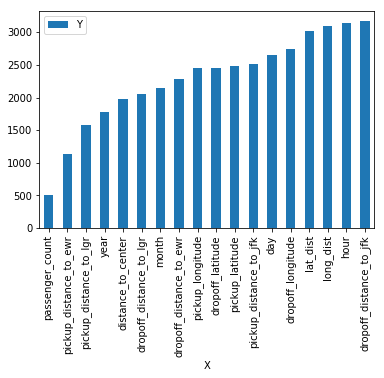

In [53]:
import matplotlib.pyplot as plt
fscores = pd.DataFrame({'X': list(model2.get_fscore().keys()), 'Y': list(model2.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

# Predict on Holdout Set

In [54]:
test = pd.read_csv('test.csv').set_index('key')
test['pickup_datetime'] = test['pickup_datetime'].str.slice(0, 16)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

# Predict on holdout set
test = transform(test)
dtest = xgb.DMatrix(test)
y_pred_test = model2.predict(dtest)

# Submit predictions

In [55]:
holdout = pd.DataFrame({'key': test.index, 'fare_amount': y_pred_test})
holdout.to_csv('submission.csv', index=False)